# **Introduction to the BDD100K Dataset**

## Overview
The BDD100K (Berkeley DeepDrive 100K) dataset is one of the most comprehensive and diverse driving datasets available for computer vision research in autonomous driving. Created by UC Berkeley's DeepDrive lab, this large-scale dataset contains 100,000 videos with diverse driving scenarios captured across different locations, weather conditions, and times of day.

## Dataset Origin and Purpose
- **Development**: Created by Berkeley DeepDrive (BDD) in 2018
- **Purpose**: To advance research in autonomous driving and traffic scene understanding
- **Collection**: Collected from diverse locations in the United States (New York, San Francisco Bay Area, etc.)
- **Funding**: Supported by multiple industry partners in the autonomous vehicle space

## Dataset Structure
The BDD100K dataset is organized into several components:

### 1. Video Data
- 100,000 high-resolution (1280×720) videos
- 40 seconds per video at 30fps (approximately 1,200 frames per video)
- Total duration: ~1,100 hours of driving footage

### 2. Annotations
The dataset includes multiple annotation types across different subsets:

#### a. Image-Level Annotations (100K images)
- Weather conditions (rainy, snowy, cloudy, etc.)
- Scene type (highway, residential, parking lot, etc.)
- Time of day (daytime, night, dawn/dusk)

#### b. Object Detection (100K images)
- 2D bounding boxes for:
  - Vehicles (cars, trucks, buses)
  - Pedestrians
  - Traffic signs/lights
  - Bicycles
  - Motorcycles
  - Other road objects
- Total of over 1.8 million labeled objects

### 3. Data Splits
The dataset is divided into:
- **Training set**: 70,000 images
- **Validation set**: 10,000 images
- **Test set**: 20,000 images

## Key Features and Strengths

### 1. Diversity
- **Geographic diversity**: Captured across multiple US cities
- **Weather diversity**: Includes various weather conditions (sunny, rainy, foggy, snowy)
- **Time diversity**: Daytime, night, dawn, and dusk scenarios
- **Scene diversity**: Urban, rural, and highway environments

### 2. Comprehensive Annotations
- Multiple annotation types (detection, segmentation, tracking) in a single dataset
- High-quality manual annotations with quality control

### 3. Balanced Distribution
- Careful balancing across different conditions to prevent bias

## Dataset Statistics

| Category | Count |
|----------|-------|
| Annotated images | 100,000 |
| Labeled objects | >1.8 million |
| Weather conditions | 4 (rainy, snowy, cloudy, clear) |
| Scene types | 6 (highway, city street, etc.) |
| Time of day | 3 (day, night, dawn/dusk) |

## Potential Use Cases in Our Project
1. **Object Detection**: Training models to detect vehicles, pedestrians, and traffic signs
2. **Semantic Segmentation**: Understanding drivable areas and road layouts
3. **Behavior Prediction**: Analyzing driver behavior and traffic patterns

## Access and Usage
The dataset is available for non-commercial research purposes through the Berkeley DeepDrive website. Users must agree to the terms of use before downloading.

## Working with the 10K Object Detection Set
For our project, we used the **10K version** of the dataset—specifically the object detection subset consisting of 10,000 annotated images. This reduced version was chosen to ensure efficient processing and analysis within our available computational resources and time constraints, while still retaining sufficient diversity and annotation quality for meaningful model training and evaluation.(7000 train, 2000 test and 1000 validation)

## References
- Original paper: "BDD100K: A Diverse Driving Dataset for Heterogeneous Multitask Learning" (Yu et al., 2020)
- Official website: https://bdd-data.berkeley.edu/
- GitHub repository: https://github.com/ucbdrive/bdd100k

This comprehensive dataset provides an excellent foundation for our project, offering rich, diverse, and well-annotated data that can help develop robust computer vision models for autonomous driving applications.

## **Importing needed libraries:**

In [77]:
import os
import json
import argparse
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont

In [19]:
# Specifying training images path
image_dir = 'Data/images/train/'

# Loading images into a list
train_images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path)
        train_images.append(img)


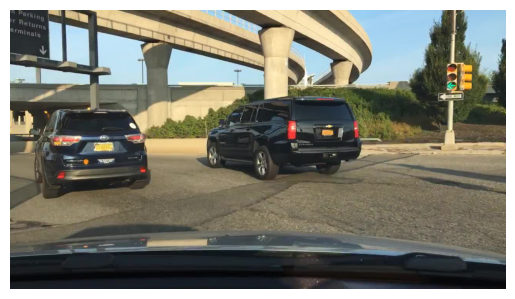

In [21]:
# Displaying an image
plt.imshow(train_images[0])
plt.axis('off')  
plt.show()

In [25]:
# Specifying validation images path
image_dir = 'Data/images/val/'  

# Loading images into a list
val_images = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path)
        val_images.append(img)


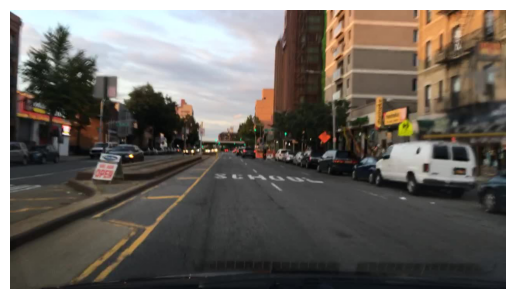

In [27]:
# Displaying an image
plt.imshow(val_images[0])
plt.axis('off')  
plt.show()

In [31]:
# On working from Kaggle:
'''
print(os.listdir('/kaggle/input'))
'''

"\nprint(os.listdir('/kaggle/input'))\n"

In [35]:
# On working from Colab:
'''
from google.colab import drive
drive.mount('/content/drive/')

os.listdir("/content/drive/MyDrive/Data")
'''

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive/\')\n\nos.listdir("/content/drive/MyDrive/Data")\n'

## **Data Exploration:**

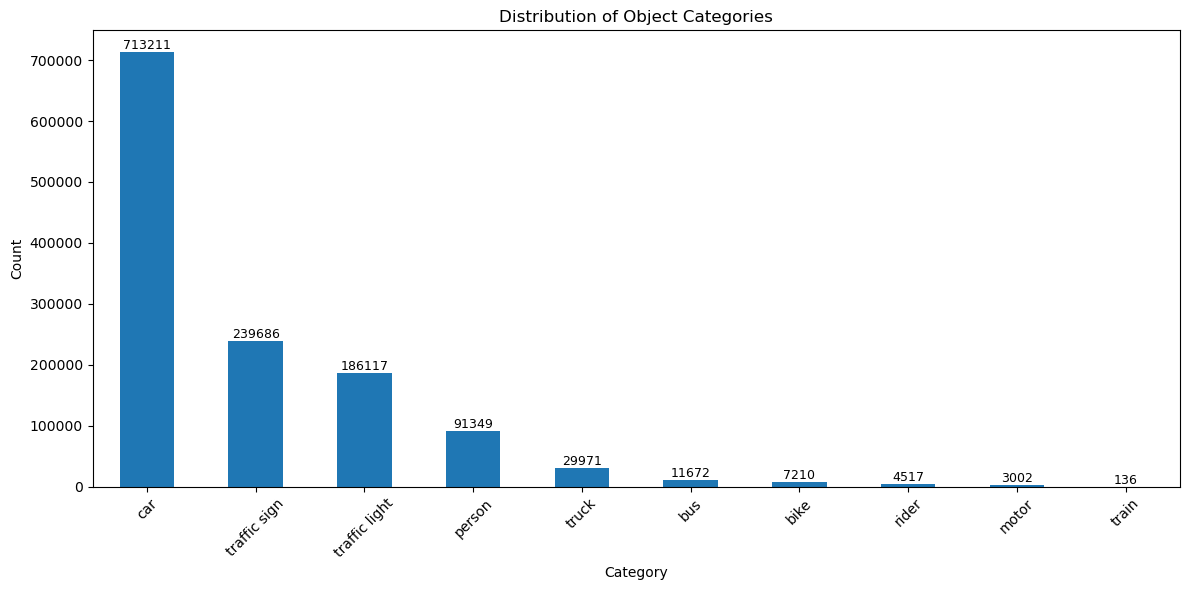

In [47]:
with open("Data/labels/bdd100k_labels_images_train.json") as f:
    data = json.load(f)

# Prepare lists for object categories and bounding box centers
categories = []
bbox_centers = []

for entry in data:
    for label in entry["labels"]:
        category = label["category"]
        if "box2d" in label:
            box = label["box2d"]
            x_center = (box["x1"] + box["x2"]) / 2
            y_center = (box["y1"] + box["y2"]) / 2

            categories.append(category)
            bbox_centers.append((x_center, y_center))

df = pd.DataFrame(bbox_centers, columns=["x_center", "y_center"])
df["category"] = categories

plt.figure(figsize=(12, 6))
category_counts = df['category'].value_counts()
ax = category_counts.plot(kind='bar')

plt.title("Distribution of Object Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Annotate each bar with the count
for i, count in enumerate(category_counts.values):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

-> Noting that there is a great bias towards certain classes like (cars, traffic lights and traffic signs) wich can be fixed by applying oversampling to the minority classes.

## Investigating the quality of the data (image resolution, label accuracy):

### *Image resolution:*

In [56]:
def check_image_resolutions(image_dirs):
    resolutions = {}
    for dir_path in image_dirs:
        for filename in os.listdir(dir_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img_path = os.path.join(dir_path, filename)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        resolutions[filename] = (width, height)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    return resolutions

# Example usage
image_dirs = [
    "Data/images/train",
    "Data/images/val"
]

resolutions = check_image_resolutions(image_dirs)

   width  height  count
0   1280     720   8012


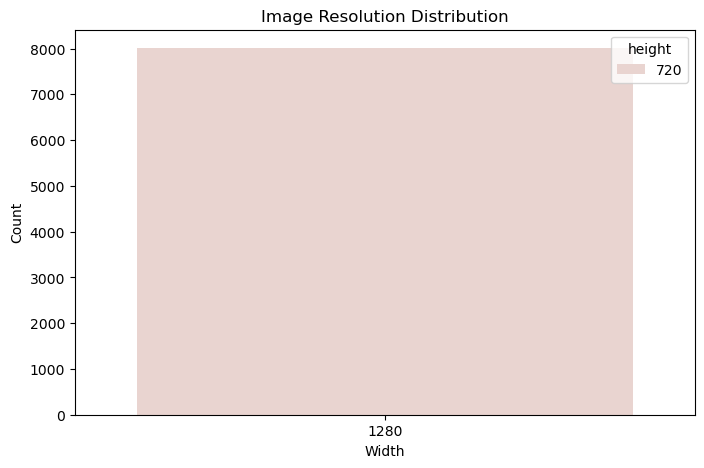

In [58]:
df_res = pd.DataFrame(resolutions.values(), columns=["width", "height"])
summary = df_res.value_counts().reset_index(name="count")
print(summary)

plt.figure(figsize=(8, 5))
sns.barplot(data=summary, x="width", y="count", hue="height")
plt.title("Image Resolution Distribution")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

### *Label accuracy:*

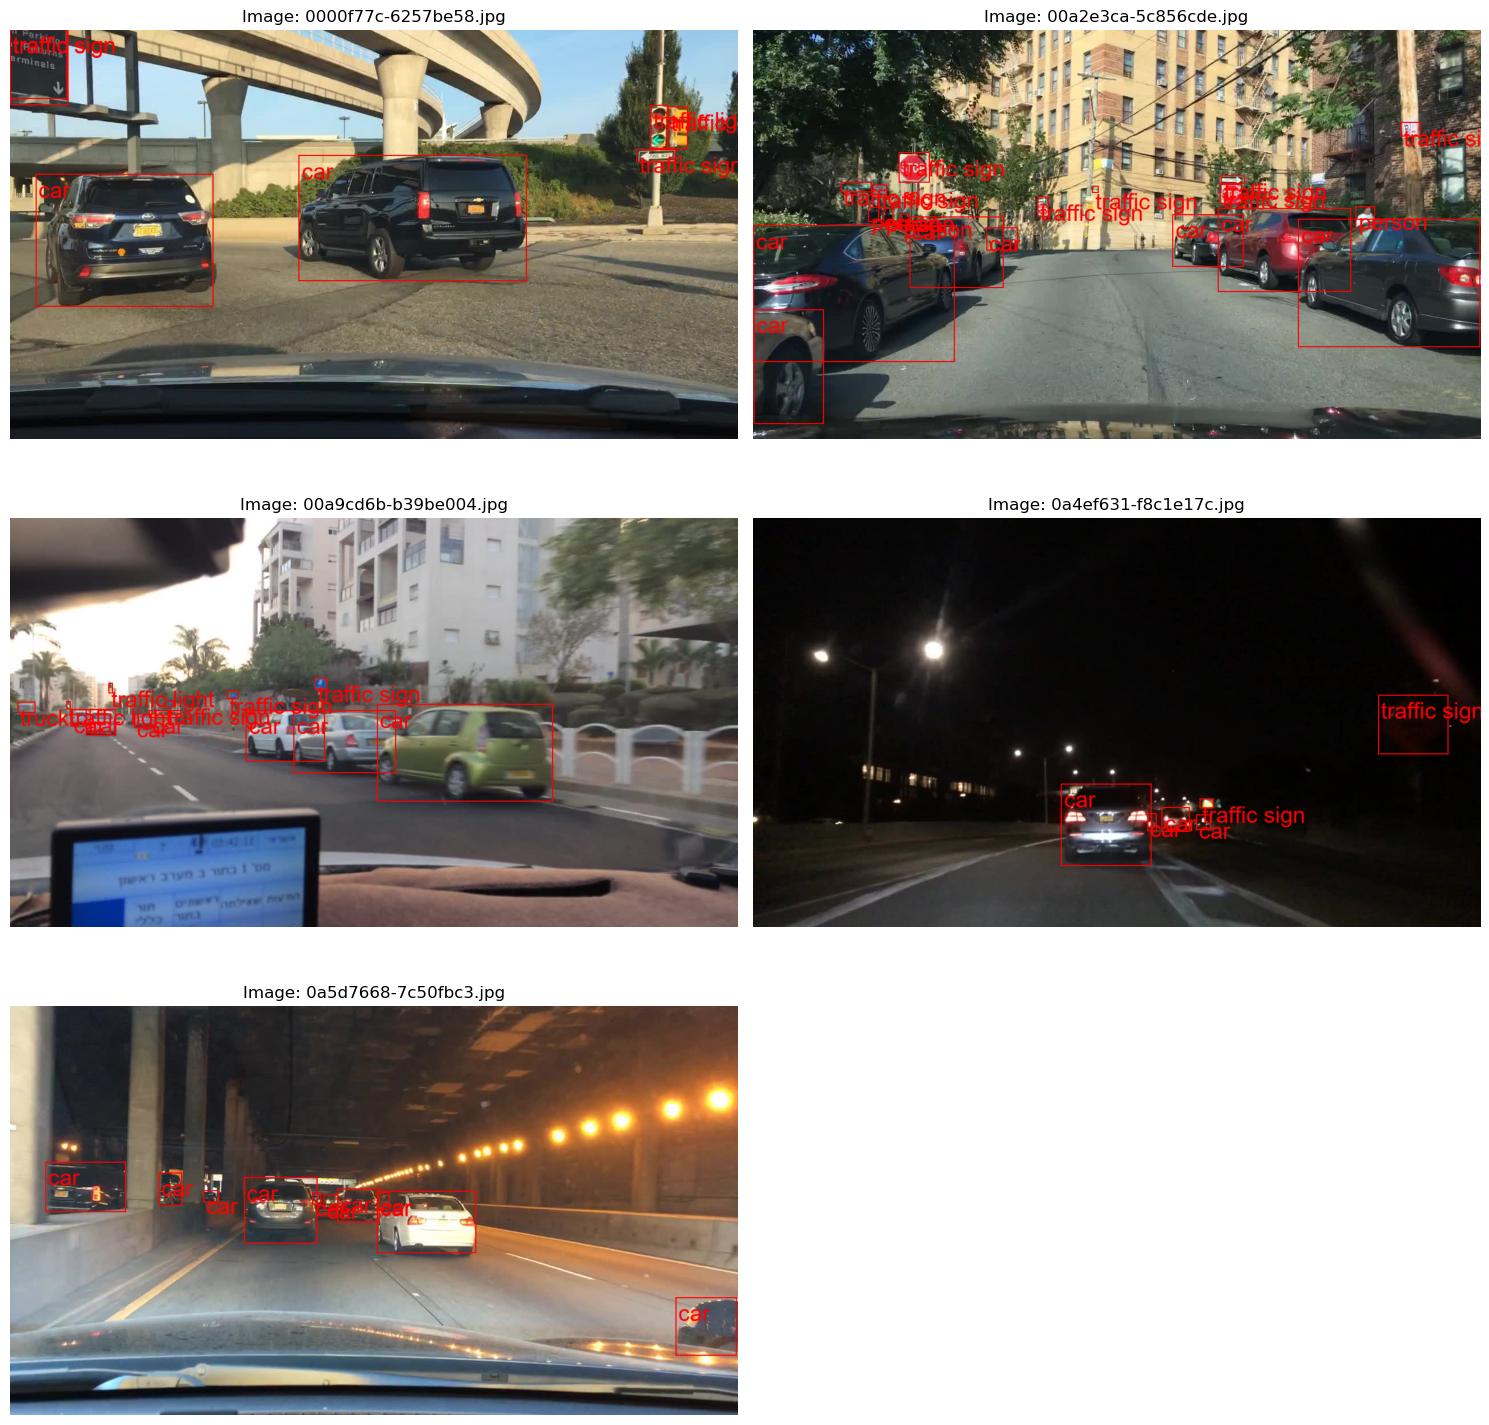

In [62]:
json_path = 'Data/labels/bdd100k_labels_images_train.json'
image_dirs = [
    "Data/Images/train"
]
image_names = [
    "0a5d7668-7c50fbc3.jpg",
    "0000f77c-6257be58.jpg",
    "00a2e3ca-5c856cde.jpg",
    "00a9cd6b-b39be004.jpg",
    "0a4ef631-f8c1e17c.jpg"
]

with open(json_path, 'r') as f:
    data = json.load(f)

samples = [item for item in data if item['name'] in image_names]

def find_image_path(image_name, directories):
    for directory in directories:
        img_path = os.path.join(directory, image_name)
        if os.path.exists(img_path):
            return img_path
    return None

def show_image_with_boxes(image_path, labels):
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 40)
    except IOError:
        font = ImageFont.load_default()

    for label in labels:
        if 'box2d' not in label:
            continue
        box = label['box2d']
        x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
        category = label['category']
        draw.rectangle([(x1, y1), (x2, y2)], outline='red', width=2)
        draw.text((x1 + 5, y1 + 5), category, fill='red', font=font)

    return image

if not samples:
    print("No matching image annotations found in the JSON file.")
else:
    plt.figure(figsize=(15, ((len(samples) + 1) // 2) * 5))  # Only one figure created

    for idx, item in enumerate(samples):
        img_name = item['name']
        img_path = find_image_path(img_name, image_dirs)
        if img_path:
            try:
                vis_img = show_image_with_boxes(img_path, item['labels'])
                plt.subplot((len(samples) + 1) // 2, 2, idx + 1)
                plt.imshow(vis_img)
                plt.title(f"Image: {img_name}")
                plt.axis('off')
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
        else:
            print(f"Image file not found: {img_name}")

    plt.tight_layout()
    plt.show()

## Investigating Environmental Diversity in our Dataset:


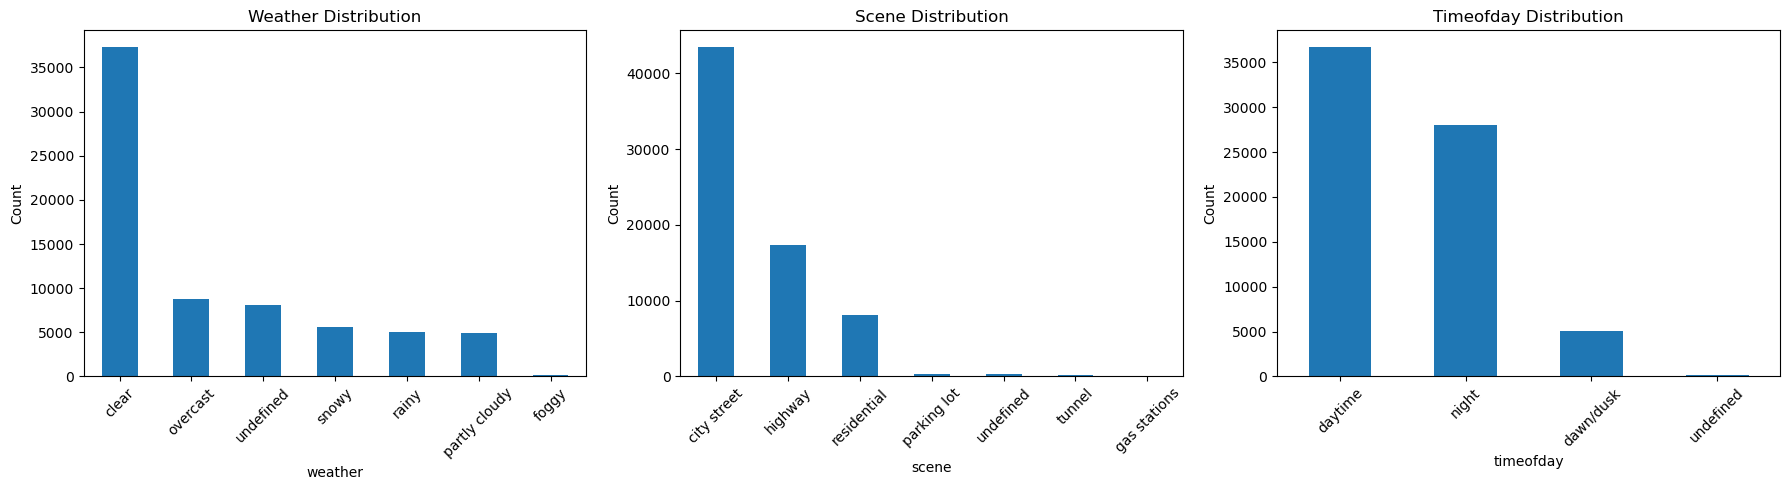

In [65]:
env_data = {
    "weather": [],
    "scene": [],
    "timeofday": []
}

for entry in data:
    attributes = entry["attributes"]
    for key in env_data:
        env_data[key].append(attributes.get(key, "unknown"))

env_df = pd.DataFrame(env_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, key in enumerate(env_data):
    env_df[key].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{key.capitalize()} Distribution")
    axes[i].set_ylabel("Count")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


## Combining Object Categories with Environmental Context:

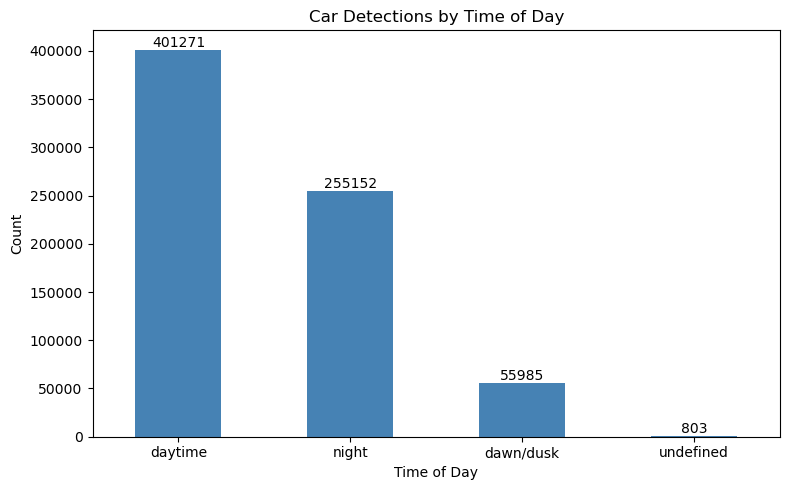

In [68]:
env_context_records = []

for entry in data:
    attributes = entry.get("attributes", {})
    weather = attributes.get("weather", "unknown")
    scene = attributes.get("scene", "unknown")
    timeofday = attributes.get("timeofday", "unknown")

    for label in entry["labels"]:
        if "box2d" in label:
            env_context_records.append({
                "category": label["category"],
                "weather": weather,
                "scene": scene,
                "timeofday": timeofday
            })

df_env_context = pd.DataFrame(env_context_records)
car_env = df_env_context[df_env_context["category"] == "car"]

plt.figure(figsize=(8, 5))
ax = car_env['timeofday'].value_counts().plot(kind='bar', color='steelblue')

plt.title("Car Detections by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.xticks(rotation=0)

# Adding count labels above bars:
for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## **Preprocessing:**

## Extracting the json file of the 10k dataset from the 100k dataset

In [79]:
def create_subset_json(images_folder, original_json_path, output_json_path):
    """
    Creates a new JSON file containing only the entries for images present in the subset folder.

    Args:
        images_folder (str): Path to the folder containing subset images
        original_json_path (str): Path to the original JSON file
        output_json_path (str): Path where the new subset JSON will be saved
    """
    try:
        # Verify input paths exist and are accessible
        if not os.path.exists(images_folder):
            raise FileNotFoundError(f"Images folder not found: {images_folder}")
        if not os.access(images_folder, os.R_OK):
            raise PermissionError(f"No read permission for images folder: {images_folder}")

        if not os.path.exists(original_json_path):
            raise FileNotFoundError(f"Original JSON file not found: {original_json_path}")
        if not os.access(original_json_path, os.R_OK):
            raise PermissionError(f"No read permission for JSON file: {original_json_path}")

        # Check output directory permissions
        output_dir = os.path.dirname(output_json_path) or '.'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)
        if not os.access(output_dir, os.W_OK):
            raise PermissionError(f"No write permission for output directory: {output_dir}")

        # Get list of image files in the subset folder
        try:
            subset_images = {f for f in os.listdir(images_folder)
                            if os.path.isfile(os.path.join(images_folder, f))}
        except PermissionError:
            raise PermissionError(f"No permission to read files in: {images_folder}")

        # Load the original JSON data
        try:
            with open(original_json_path, 'r') as f:
                original_data = json.load(f)
        except json.JSONDecodeError:
            raise ValueError(f"Invalid JSON format in: {original_json_path}")

        # Filter entries to only include those with images in the subset
        subset_data = [entry for entry in original_data if entry.get('name') in subset_images]

        # Save the subset data to a new JSON file
        try:
            with open(output_json_path, 'w') as f:
                json.dump(subset_data, f, indent=2)
        except PermissionError:
            raise PermissionError(f"No permission to write to: {output_json_path}")

        print(f"Successfully created subset JSON with {len(subset_data)} entries")
        print(f"Output saved to: {os.path.abspath(output_json_path)}")
        return True

    except Exception as e:
        print(f"Error: {str(e)}", file=sys.stderr)
        return False

***Extracting json items of train images:***

In [ ]:
'''
create_subset_json("Data/Images/train",
                       "Data/labels/bdd100k_labels_images_train.json",
                       "Data/labels/bdd10k_lables_train.json")
'''

***Extracting json items for validation images***

In [ ]:
'''
create_subset_json("/content/drive/MyDrive/Data/Images/val",
                       "/content/drive/MyDrive/Data/labels/bdd100k_labels_images_val.json",
                       "/content/drive/MyDrive/Data/labels/bdd10k_lables_val.json")
'''

### Mapping format of lables "Converting json lables to YOLO compatable format (.txt)"

In [86]:
CLASSES = ["car", "rider", "train", "person", "bus", "truck", "bike", "motor", "traffic light", "traffic sign"]
CLASS_MAP = {name: idx for idx, name in enumerate(CLASSES)}

def get_bbox_from_polygon(points):
    x_coords = [pt[0] for pt in points]
    y_coords = [pt[1] for pt in points]
    return [min(x_coords), min(y_coords), max(x_coords), max(y_coords)]

def convert_json_to_yolo(json_dir, output_dir, images_dir=None, default_img_w=1280, default_img_h=720):
    """
    Convert JSON annotations to YOLO format.

    Args:
        json_dir: Path to input JSON file
        output_dir: Directory to save YOLO .txt files
        images_dir: Path to images folder (optional, for getting actual dimensions)
        default_img_w: Default width if image not found (optional)
        default_img_h: Default height if image not found (optional)
    """
    os.makedirs(output_dir, exist_ok=True)

    with open(json_dir, "r", encoding="utf-8") as f:
        data = json.load(f)

    for i, item in enumerate(data):
        image_name = item.get("name", f"image_{i}.jpg")
        base_name = os.path.splitext(image_name)[0]

        img_w, img_h = default_img_w, default_img_h
        if images_dir:
            img_path = os.path.join(images_dir, image_name)
            try:
                with Image.open(img_path) as img:
                    img_w, img_h = img.size
            except (FileNotFoundError, AttributeError):
                print(f"[!] Warning: Could not get dimensions for {image_name}, using defaults")

        labels = item.get("labels", [])

        label_path = os.path.join(output_dir, base_name + ".txt")
        with open(label_path, "w") as out_file:
            for label in labels:
                class_name = label.get("category")
                if not class_name or class_name not in CLASS_MAP:
                    continue

                class_id = CLASS_MAP[class_name]

                if "box2d" in label:
                    box = label["box2d"]
                    x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
                elif "poly2d" in label:
                    vertices = label["poly2d"][0]["vertices"]
                    x1, y1, x2, y2 = get_bbox_from_polygon(vertices)
                else:
                    continue

                # Normalize to YOLO format:
                x_center = ((x1 + x2) / 2) / img_w
                y_center = ((y1 + y2) / 2) / img_h
                width = abs(x2 - x1) / img_w
                height = abs(y2 - y1) / img_h

                # Ensure coordinates are valid:
                x_center = max(0, min(1, x_center))
                y_center = max(0, min(1, y_center))
                width = max(0, min(1, width))
                height = max(0, min(1, height))

                out_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    print(f"[✓] Converted {len(data)} image annotations to YOLO format in '{output_dir}'.")

***Mapping labelling format for training and validation***

In [91]:
'''
convert_json_to_yolo(
    json_dir="Data/labels/bdd10k_lables_train.json",
    output_dir="Data/labels/train",
    images_dir="Data/Images/train"
    )
'''

'\nconvert_json_to_yolo(\n    json_dir="Data/labels/bdd10k_lables_train.json",\n    output_dir="Data/labels/train",\n    images_dir="Data/Images/train"\n    )\n'

In [93]:
'''
convert_json_to_yolo(
    json_dir="Data/labels/bdd10k_lables_val.json",
    output_dir="Data/labels/val",
    images_dir="Data/Images/val"
    )
'''

'\nconvert_json_to_yolo(\n    json_dir="Data/labels/bdd10k_lables_val.json",\n    output_dir="Data/labels/val",\n    images_dir="Data/Images/val"\n    )\n'

### Image resizing:

In YOLOv11 (and YOLOv8 from Ultralytics), image resizing and label adjustment **are handled automatically**. When you train or predict, images are resized to the specified size (e.g., 640x640) with letterbox padding to maintain the original aspect ratio. The bounding box labels are also automatically scaled to match the new image size, **so you don't need to adjust them manually.**

### Data Augmentation

During YOLOv11 model training, various data augmentation techniques can be applied to enhance generalization. YOLOv11 supports methods such as **HSV** augmentation (adjusting hue, saturation, and value), random **scaling**, and **rotation**, which help simulate different real-world conditions. These augmentations introduce variability in the input data, allowing the model to learn more diverse features and improve performance on unseen scenarios.

## **Loading the Pre-trained model for applying Hyper-parameters tunnig and transfer learning**


#### Installing ultralytics

In [ ]:
!git clone https://github.com/ultralytics/yolov11.git


In [4]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.6 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

### Preparing the dataset.yaml file for model training

In [ ]:
os.makedirs("data", exist_ok=True)

custom_yaml = """
train: /kaggle/input/bdd10k/images/train/
val: /kaggle/input/bdd10k/images/val/

nc: 10
names: ['bike', 'bus', 'car', 'motor', 'person', 'rider', 'traffic light', 'traffic sign', 'train', 'truck']
"""
with open("dataset.yaml", "w") as f:
    f.write(custom_yaml)

### Preparing augmentation parameters in augment.yaml file

In [ ]:
augment_yaml = """
augment: True

# Color jittering (simulate lighting/weather variations)
hsv_h: 0.015     # Hue variation
hsv_s: 0.7       # Saturation variation
hsv_v: 0.4       # Brightness variation

# Flipping (simulate camera angles, should avoid flipping traffic signs!)
fliplr: 0.0      # Horizontal flip
flipud: 0.0      # Avoid vertical flipping (not realistic for driving scenes)

mosaic: 0.8      # Combine 4 images into 1 (YOLO trick to improve generalization)
mixup: 0.2       # Blend images/labels (for regularization)
copy_paste: 0.1  # Copy objects from one image into another

scale: 0.5
translate: 0.1
shear: 0.0
perspective: 0.0
rotate: 0.0

"""
with open("/content/drive/MyDrive/Data/augment.yaml", "w") as f:
    f.write(augment_yaml)

### Loading the Pretrained YOLO model

In [5]:
from ultralytics import YOLO
model = YOLO('/kaggle/input/bdd10k/yolov11s.pt') 

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Activating model to run on gpu using cuda

In [ ]:
model.to('cuda')

### Applying **Evolution** Hyper-parameters Tunning for our YOLO model

In [ ]:
# Run Hyperparameter Evolution
model.tune(
    data='/content/drive/MyDrive/Data/data.yaml',
    epochs=5,
    iterations=5,     # Number of tuning trials
    batch=32,         # Smaller batch size for faster tuning
    imgsz=640,
)

In [ ]:
from IPython.display import Image, display

tune_dir = 'runs/detect/tune2'
image_files = [f for f in os.listdir(tune_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

for img in image_files:
    display(Image(filename=os.path.join(tune_dir, img)))

### Generating Best Hyperparameters yaml file resulting from model tuning:



In [ ]:
hyp_yaml = """

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
box: 7.5
cls: 0.5
dfl: 1.5
hsv_h: 0.015
hsv_s: 0.7
hsv_v: 0.4
degrees: 0.0
translate: 0.1
scale: 0.5
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
bgr: 0.0
mosaic: 1.0
mixup: 0.0
cutmix: 0.0
copy_paste: 0.0

"""

with open("hyp.yaml", "w") as f:
    f.write(hyp_yaml)

### Using the resulting hyper-parameters in model training (with freezing the backbone layers of the model to apply transfer learning)

In [ ]:
model.train(
    data='dataset.yaml',
    epochs=50,
    imgsz=640,
    batch=64,
    cfg='hyp.yaml',
    workers = 5,
    freeze=10,
    project='results',
    name='yolov11s_bdd10k_transfer_learning',
    exist_ok=True
)


## Model exporting as ONNX format

In [ ]:
model.export(
    format='onnx',
    dynamic=True,
    optimize=True,
    imgsz=640
)

# Test and Metrics calculation

### Loading model

In [111]:
model = YOLO('/kaggle/working/results/yolov11s_bdd10k_transfer_learning/weights/best.pt')

### Predicting using test dataset and calculate performance metrics


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1009 /kaggle/input/bdd10k/images/val/Copy of b7b3a558-45775f2e.jpg: 384x640 4 bikes, 1 truck, 13.6ms
image 2/1009 /kaggle/input/bdd10k/images/val/Copy of b7bcc17a-72df68f9.jpg: 384x640 20 bikes, 1 person, 1 train, 2 trucks, 10.8ms
image 3/1009 /kaggle/input/bdd10k/images/val/Copy of b7bcc17a-7feae7dd.jpg: 384x640 2 bikes, 1 train, 10.9ms
image 4/1009 /kaggle/input/bdd10k/images/val/b1c66a42-6f7d68ca.jpg: 384x640 23 bikes, 2 trains, 2 trucks, 10

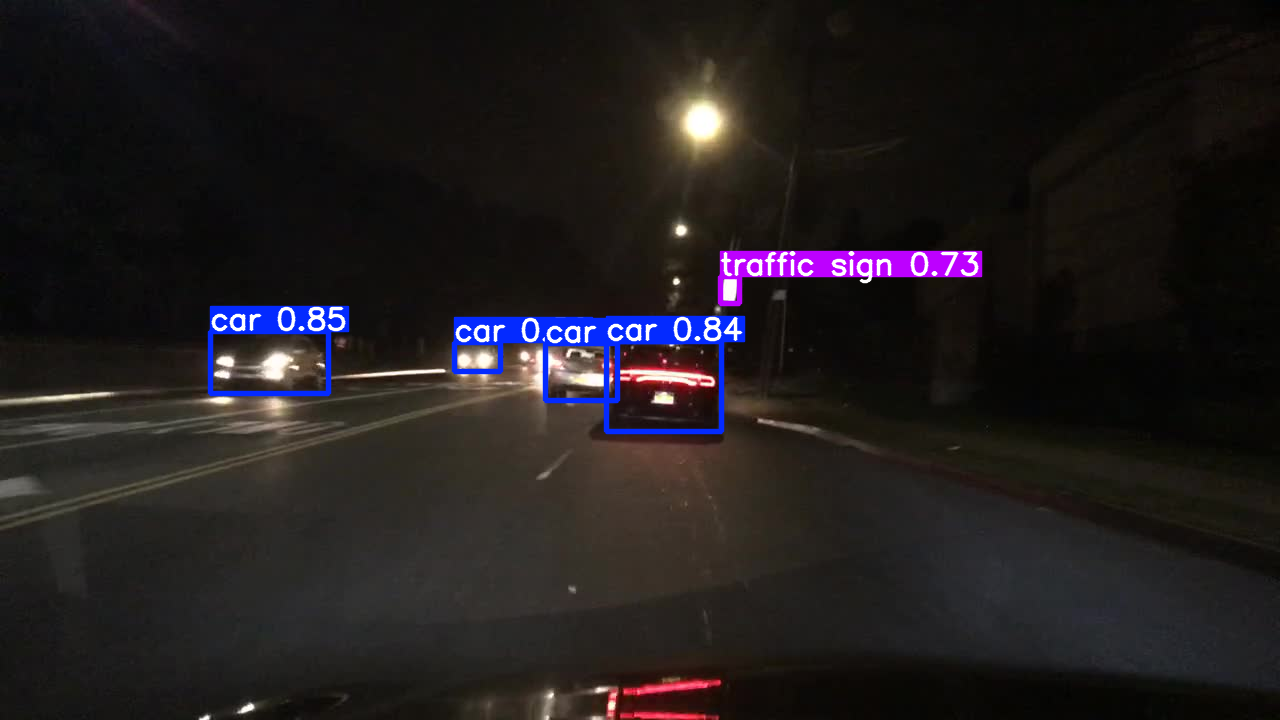

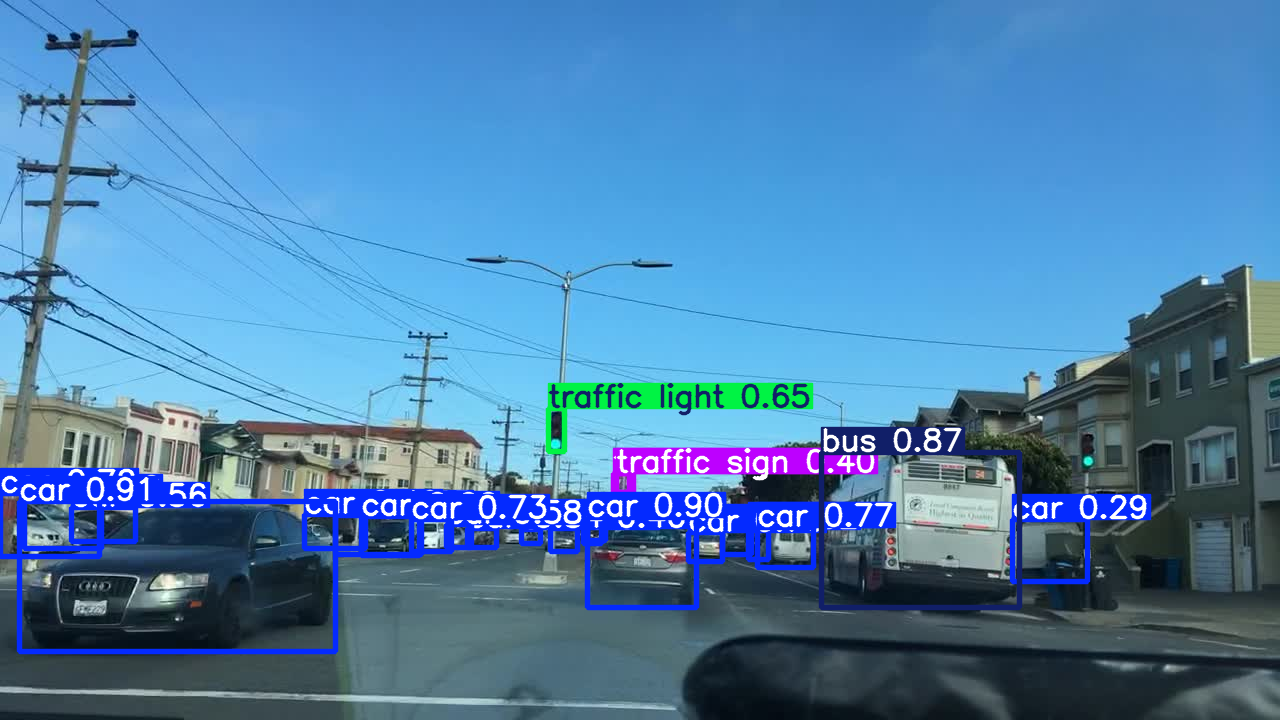

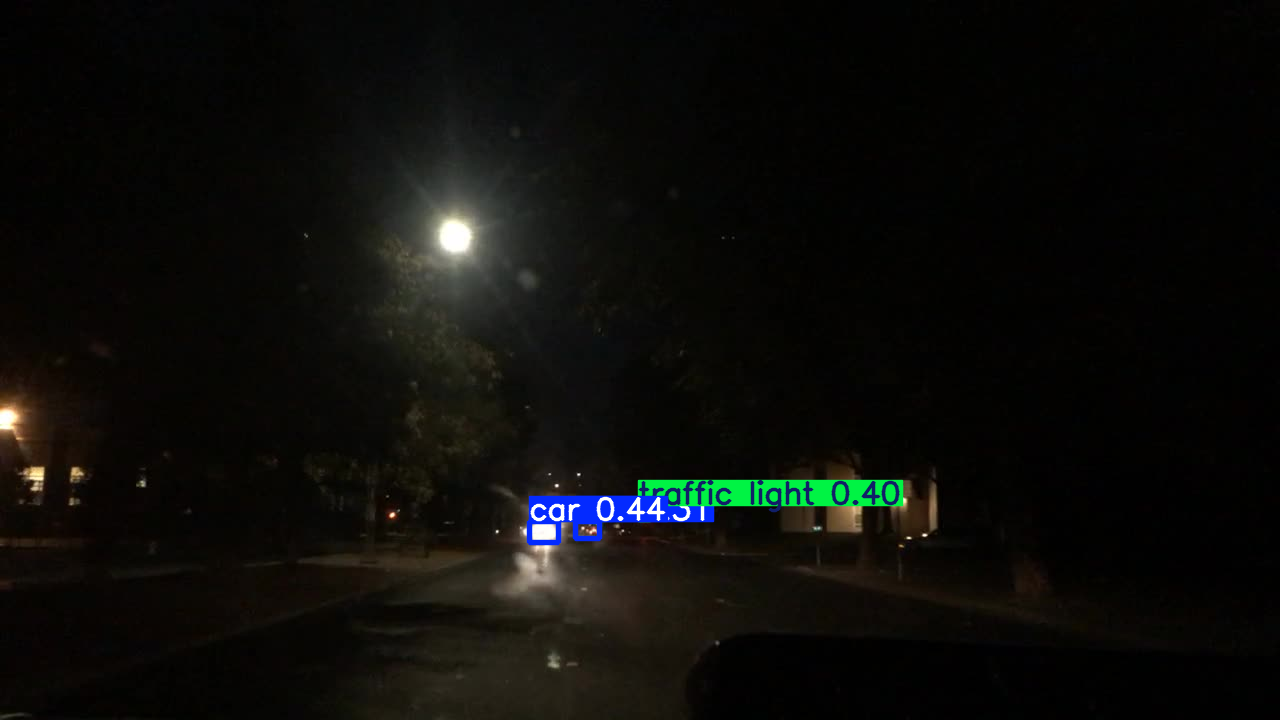

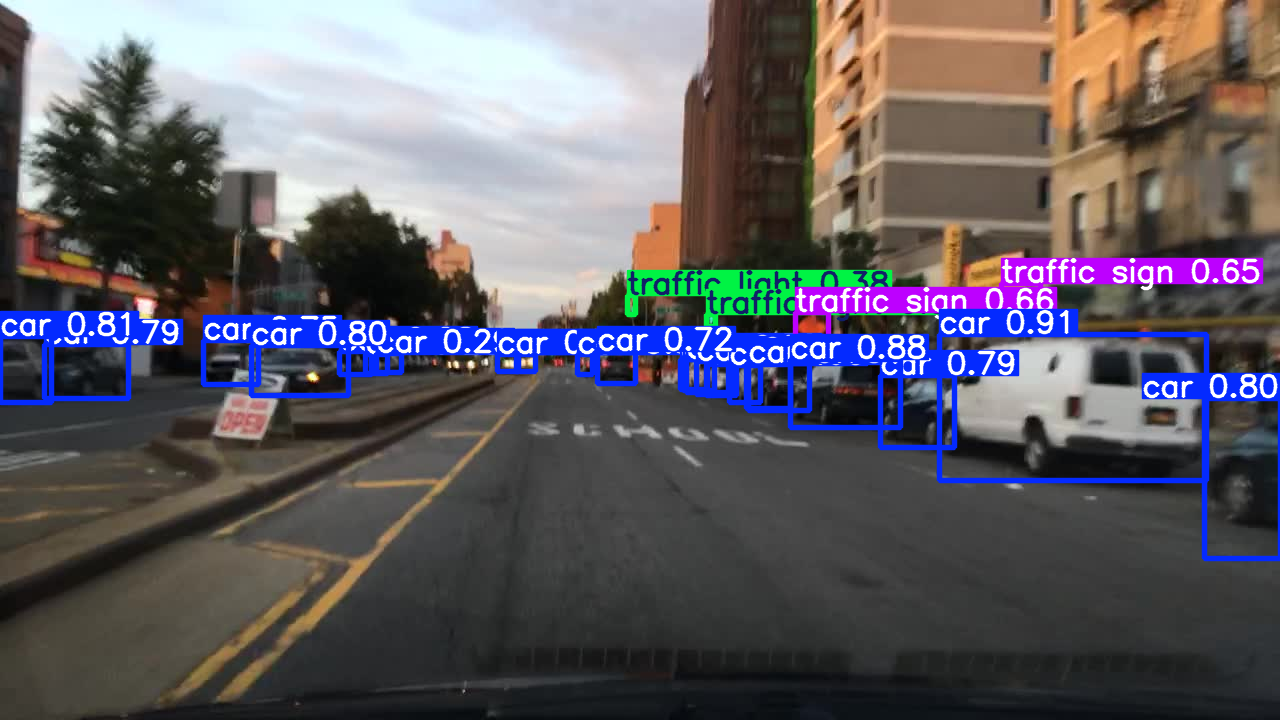

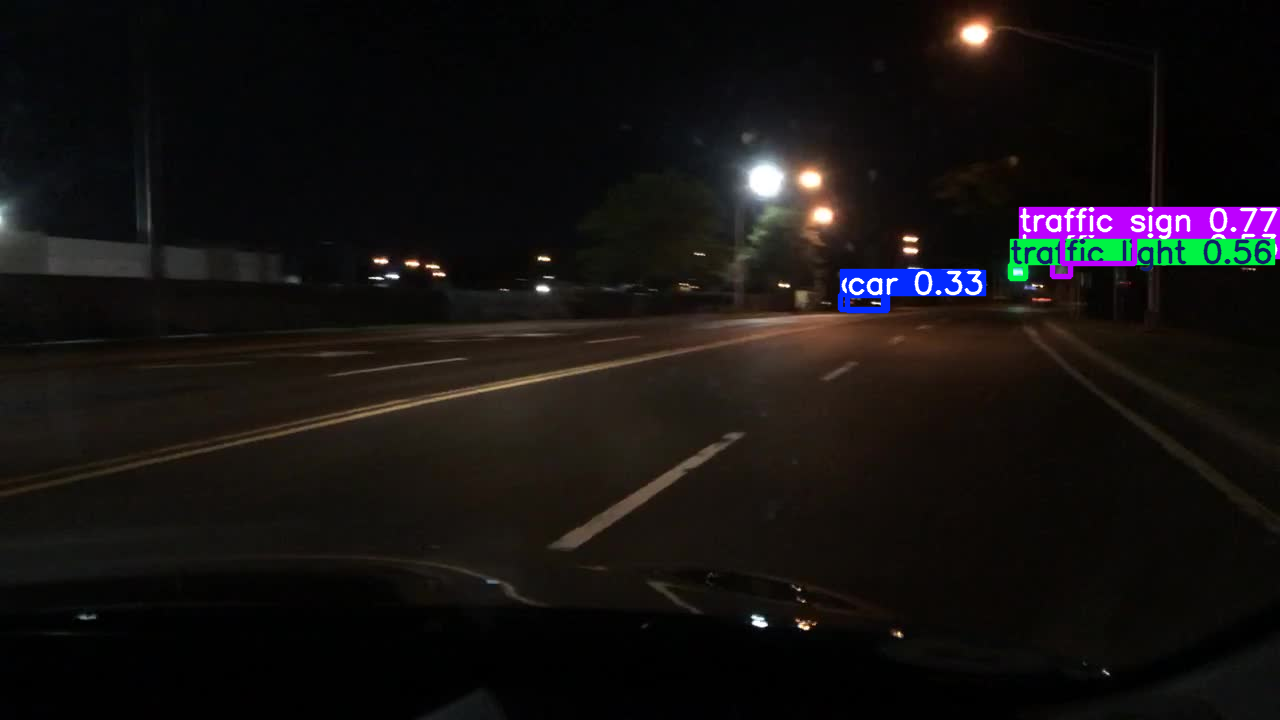

Ultralytics 8.3.129 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 98.3±37.4 MB/s, size: 58.1 KB)


val: Scanning /kaggle/input/bdd10k/labels/val... 1000 images, 9 backgrounds, 0 corrupt: 100%|██████████| 1009/1009 [00:01<00:00, 894.88it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/bdd10k/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:14<00:00,  4.45it/s]


                   all       1009      18426      0.627       0.39      0.412      0.235
                  bike        990      10050      0.711      0.646      0.697      0.427
                   bus         47         60       0.54      0.267       0.32      0.156
                   car          1          1          1          0          0          0
                 motor        325       1422      0.606      0.506      0.533       0.26
                person        114        136       0.53      0.529      0.534      0.415
                 rider        245        384      0.466      0.474      0.467      0.331
         traffic light         52         67      0.507      0.328      0.312      0.186
          traffic sign         32         51      0.656      0.255      0.297      0.136
                 train        571       2744      0.622      0.423      0.459      0.173
                 truck        823       3511      0.636       0.47      0.502      0.264


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 6.0ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val7
Precision: 0.6273
Recall: 0.3899
mAP@0.5: 0.4120
mAP@0.5:0.95: 0.2348


In [59]:
custom_labels = ["car", "train", "motor", "person", "bus", "truck", "bike", "rider", "traffic light", "traffic sign"]

results = model.predict('/kaggle/input/bdd10k/images/val', save=False)

for result in results[:5]:
    result.names = {i: label for i, label in enumerate(custom_labels)}
    result.show()

metrics = model.val(data='/kaggle/working/dataset.yaml')  

print(f"Precision: {metrics.box.p.mean():.4f}")
print(f"Recall: {metrics.box.r.mean():.4f}")
print(f"mAP@0.5: {metrics.box.map50.mean():.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map.mean():.4f}")
